In [1]:
import numpy as np
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.visualization import simple_norm

%matplotlib inline
import pylab as pl

In [2]:
import reproject

In [3]:
import regions

In [4]:
brick_center = SkyCoord(0.257, 0.018, unit=(u.deg, u.deg), frame='galactic')

In [5]:
co_image = fits.open('/orange/adamginsburg/cmz/CHIMPS/12CO_CMZ_INTEG_LB.fits')
# co_image_cutout = Cutout2D(co_image[0].data, SkyCoord('17:46:12.752 -28:43:52.4', unit=(u.h, u.deg), frame='fk5'), size=10*u.arcsec, wcs=WCS(co_image[0].header)) ## this is that interesting cluster zone
co_image_cutout = Cutout2D(co_image[0].data, brick_center, size=5*u.arcmin, wcs=WCS(co_image[0].header))
coheader = co_image[0].header
cowcs = WCS(coheader)

Set OBSGEO-B to    19.822842 from OBSGEO-[XYZ].
Set OBSGEO-H to       -3.003 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    19.822842 from OBSGEO-[XYZ].
Set OBSGEO-H to       -3.003 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [6]:
from spectral_cube import SpectralCube
cube = SpectralCube.read('/orange/adamginsburg/cmz/CHIMPS/12CO_GC_359-000_mosaic.fits')

In [48]:
cube_13co = SpectralCube.read('/orange/adamginsburg/cmz/APEX_Ginsburg/apex_13co_2014_merge.fits')

if os.path.exists('/orange/adamginsburg/cmz/APEX_Ginsburg/apex_13co_2014_merge_mom0.fits'):
    mom0_13co = fits.open('/orange/adamginsburg/cmz/APEX_Ginsburg/apex_13co_2014_merge_mom0.fits')[0]
else:
    mom0_13co = cube_13co.moment0(axis=0)
    mom0_13co.hdu.writeto('/orange/adamginsburg/cmz/APEX_Ginsburg/apex_13co_2014_merge_mom0.fits')
    mom0_13co = mom0_13co.hdu

In [7]:
ppmap_cdens_full = fits.open('/orange/adamginsburg/cmz/ppmap/PPMAP_Results/l000_results/l000_cdens.fits')
ppmap_tem_full = fits.open('/orange/adamginsburg/cmz/ppmap/PPMAP_Results/l000_results/l000_temp.fits')

ppmap_col = Cutout2D(ppmap_cdens_full[0].data,
                     brick_center,
                     size=5*u.arcmin, wcs=WCS(ppmap_cdens_full[0].header))
ppmap_tem = Cutout2D(ppmap_tem_full[0].data,
                     brick_center,
                     size=5*u.arcmin, wcs=WCS(ppmap_tem_full[0].header))

In [8]:
brickreg = regions.Regions.read('/blue/adamginsburg/adamginsburg/jwst/brick/regions_/brick_polygon.reg')

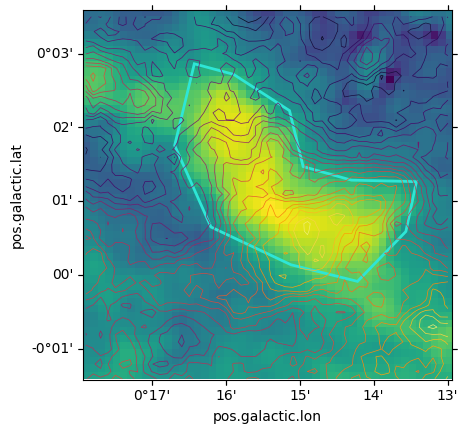

In [9]:
fig = pl.figure(dpi=100)
ax = fig.add_subplot(projection=ppmap_col.wcs)
pl.imshow(ppmap_col.data, norm=simple_norm(ppmap_col.data, stretch='log'))
ax.contour(co_image_cutout.data, transform=ax.get_transform(co_image_cutout.wcs), cmap='inferno', levels=20, linewidths=[0.5]*20)
brickreg[0].to_pixel(ax.wcs).plot(ax=ax);

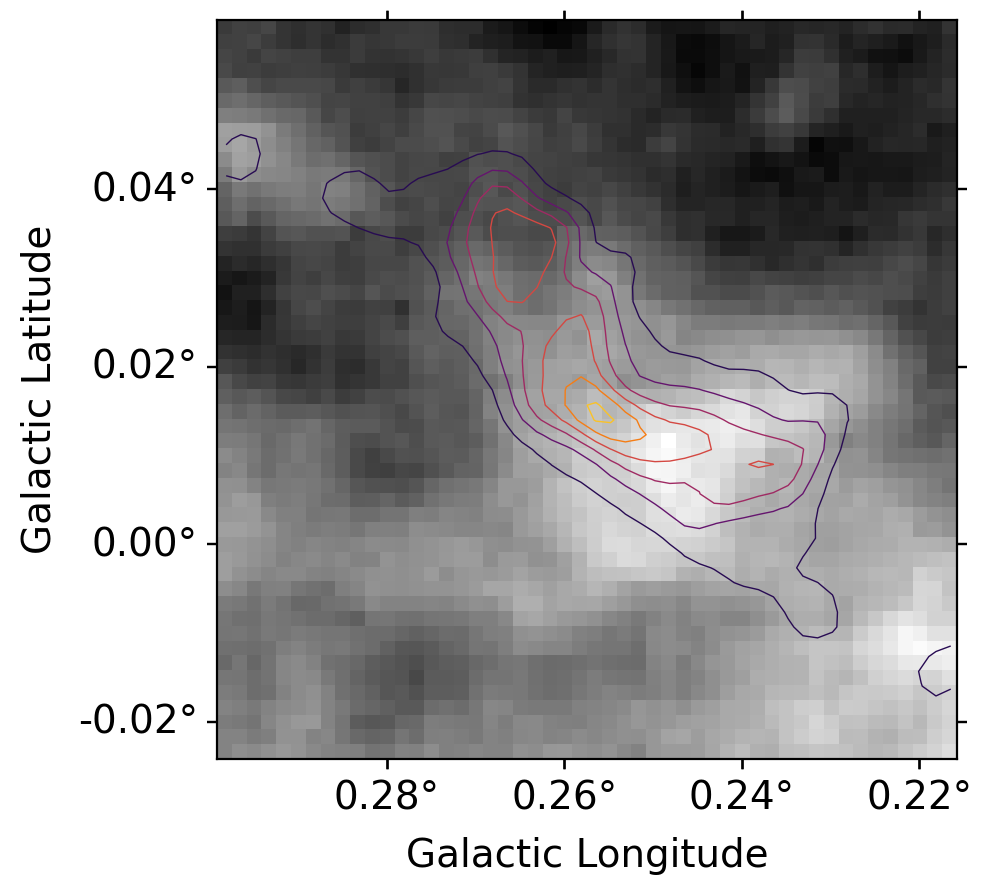

In [19]:
fig = pl.figure(dpi=200)
ax = fig.add_subplot(projection=co_image_cutout.wcs)
pl.imshow(co_image_cutout.data, norm=simple_norm(co_image_cutout.data, stretch='linear', ),
          cmap='gray')
ax.contour(ppmap_col.data, transform=ax.get_transform(ppmap_col.wcs),
           cmap='inferno', levels=6, linewidths=[0.5]*20)
ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Latitude')
ax.xaxis.set_units(u.deg)
ax.yaxis.set_units(u.deg)
lon = ax.coords['glon']
lat = ax.coords['glat']
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')

pl.savefig("PPMAP_on_CO32.pdf", dpi=200, bbox_inches='tight')
pl.savefig("PPMAP_on_CO32.png", dpi=200, bbox_inches='tight')
#brickreg[0].to_pixel(ax.wcs).plot(ax=ax);

In [11]:
ppmapcdens_to_co,_ = reproject.reproject_interp(ppmap_cdens_full, coheader)

In [12]:
ppmaptem_to_co,_ = reproject.reproject_interp(ppmap_tem_full, coheader)

In [13]:
brickpreg = brickreg[0].to_pixel(WCS(co_image[0].header))

In [14]:
pl.rcParams['figure.dpi'] = 100
pl.rcParams['font.size'] = 14

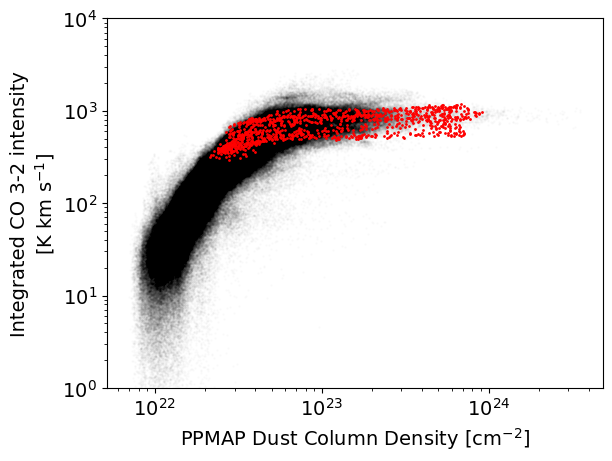

In [15]:
# whole CMZ
pl.scatter(ppmapcdens_to_co.ravel()*1e20, co_image[0].data.ravel(), s=1, c='k', alpha=0.01)

co = brickpreg.to_mask().cutout(co_image[0].data)
du = brickpreg.to_mask().cutout(ppmapcdens_to_co)

pl.scatter(du.ravel()*1e20, co.ravel(), s=1, c='r')
pl.loglog();
pl.ylim(1,1e4)
pl.xlabel("PPMAP Dust Column Density [cm$^{-2}$]")
pl.ylabel("Integrated CO 3-2 intensity\n[K km s$^{-1}$]");

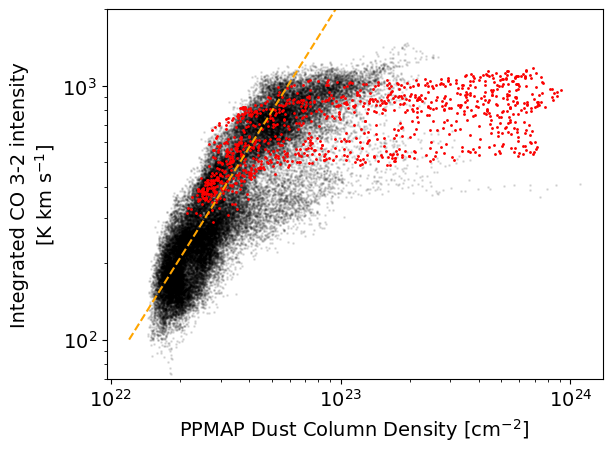

In [16]:
# dust ridge
dustridge_dust = Cutout2D(ppmapcdens_to_co,
                     brick_center,
                     size=[30*u.arcmin, 15*u.arcmin],
                     wcs=cowcs)

dustridge_co = Cutout2D(co_image[0].data,
                     brick_center,
                     size=[30*u.arcmin, 15*u.arcmin],
                     wcs=cowcs)

pl.scatter(dustridge_dust.data.ravel()*1e20, dustridge_co.data.ravel(), s=1, c='k', alpha=0.1)

co = brickreg[0].to_pixel(dustridge_co.wcs).to_mask().cutout(dustridge_co.data)
du = brickreg[0].to_pixel(dustridge_co.wcs).to_mask().cutout(dustridge_dust.data)

pl.scatter(du.ravel()*1e20, co.ravel(), s=1, c='r')
pl.plot([1.2e22,0.95e23], [1e2, 2e3], linestyle='--', color='orange')
pl.loglog();
pl.ylim(70,2e3)
pl.xlabel("PPMAP Dust Column Density [cm$^{-2}$]")
pl.ylabel("Integrated CO 3-2 intensity\n[K km s$^{-1}$]");
pl.savefig("BrickOnDustRidge_CO32_vs_ppmapdust.pdf", dpi=150, bbox_inches='tight')
pl.savefig("BrickOnDustRidge_CO32_vs_ppmapdust.png", dpi=150, bbox_inches='tight')

### temperature

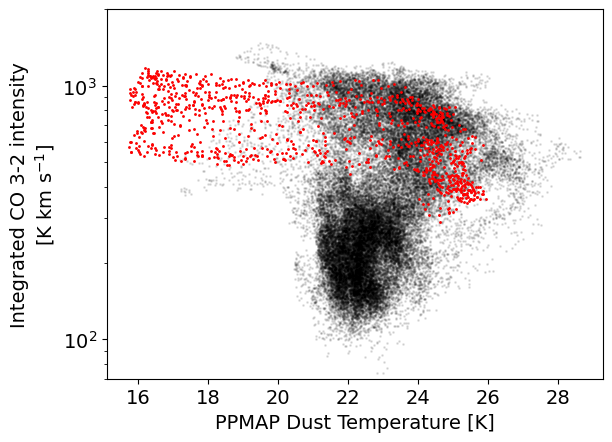

In [82]:
# dust ridge
dustridge_dust_tem = Cutout2D(ppmaptem_to_co,
                     brick_center,
                     size=[30*u.arcmin, 15*u.arcmin],
                     wcs=cowcs)

dustridge_co = Cutout2D(co_image[0].data,
                     brick_center,
                     size=[30*u.arcmin, 15*u.arcmin],
                     wcs=cowcs)

pl.scatter(dustridge_dust_tem.data.ravel(), dustridge_co.data.ravel(), s=1, c='k', alpha=0.1)

co = brickreg[0].to_pixel(dustridge_co.wcs).to_mask().cutout(dustridge_co.data)
du = brickreg[0].to_pixel(dustridge_co.wcs).to_mask().cutout(dustridge_dust_tem.data)

pl.scatter(du.ravel(), co.ravel(), s=1, c='r')
pl.semilogy();
pl.ylim(70,2e3)
pl.xlabel("PPMAP Dust Temperature [K]")
pl.ylabel("Integrated CO 3-2 intensity\n[K km s$^{-1}$]");
pl.savefig("BrickOnDustRidge_CO32_vs_ppmapdusttem.pdf", dpi=150, bbox_inches='tight')
pl.savefig("BrickOnDustRidge_CO32_vs_ppmapdusttem.png", dpi=150, bbox_inches='tight')

## Johnston version

In [71]:
cocube_Johnston = SpectralCube.read('/orange/adamginsburg/brick_alma_linesurvey/archive_brick/Johnston2014/13co.fits').to(u.K).with_spectral_unit(u.km/u.s)
mom0_Johnston = cocube_Johnston.moment0(axis=0)
cocube_Johnston

SpectralCube with shape=(30, 447, 272) and unit=K:
 n_x:    272  type_x: RA---SIN  unit_x: deg    range:   266.515951 deg:  266.558879 deg
 n_y:    447  type_y: DEC--SIN  unit_y: deg    range:   -28.741416 deg:  -28.679471 deg
 n_s:     30  type_s: VRAD      unit_s: km / s  range:      -40.005 km / s:     105.031 km / s

In [66]:
mom0_13co_to_pp,_ = reproject.reproject_interp(mom0_13co, coheader)

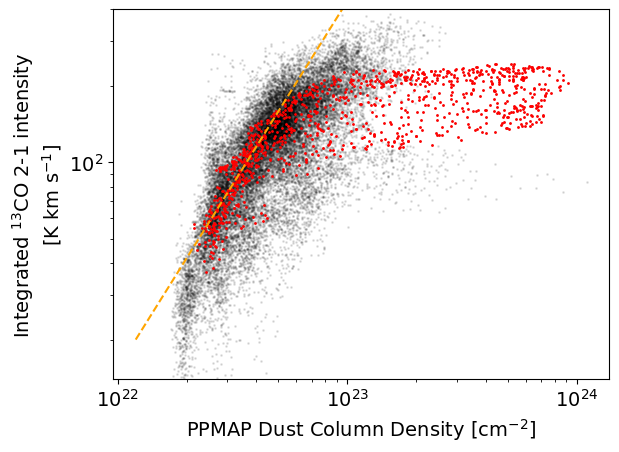

In [58]:
dustridge_13co = Cutout2D(mom0_13co_to_pp,
                          brick_center,
                          size=[30*u.arcmin, 15*u.arcmin],
                          wcs=cowcs)

pl.scatter(dustridge_dust.data.ravel()*1e20, dustridge_13co.data.ravel(), s=1, c='k', alpha=0.1)

co_13_lo = brickreg[0].to_pixel(dustridge_13co.wcs).to_mask().cutout(dustridge_13co.data)
co_13_hi = brickreg[0].to_pixel(mom0_Johnston.wcs).to_mask().cutout(mom0_Johnston.value)
du = brickreg[0].to_pixel(dustridge_co.wcs).to_mask().cutout(dustridge_dust.data)

pl.scatter(du.ravel()*1e20, co_13_lo.ravel(), s=1, c='r')
co12to13 = 5
pl.plot([1.2e22,0.95e23], [1e2/co12to13, 2e3/co12to13], linestyle='--', color='orange')
pl.loglog();
pl.ylim(70/co12to13,2e3/co12to13)
pl.xlabel("PPMAP Dust Column Density [cm$^{-2}$]")
pl.ylabel("Integrated $^{13}$CO 2-1 intensity\n[K km s$^{-1}$]");
pl.savefig("BrickOnDustRidge_13CO21_lores_vs_ppmapdust.pdf", dpi=150, bbox_inches='tight')
pl.savefig("BrickOnDustRidge_13CO21_lores_vs_ppmapdust.png", dpi=150, bbox_inches='tight')

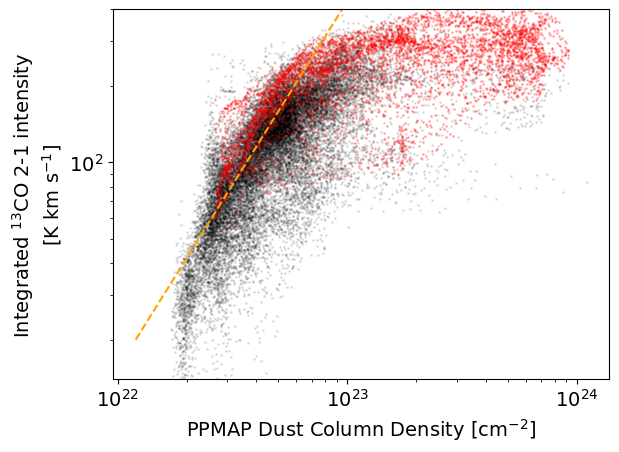

In [75]:
pp_to_johnston,_ = reproject.reproject_interp(ppmap_cdens_full, mom0_Johnston.hdu.header)

pl.scatter(dustridge_dust.data.ravel()*1e20, dustridge_13co.data.ravel(), s=1, c='k', alpha=0.1)

pl.scatter(pp_to_johnston[::5,::5].ravel()*1e20, mom0_Johnston.value[::5,::5].ravel(), s=1, c='r', alpha=0.25)
co12to13 = 5
pl.plot([1.2e22,0.95e23], [1e2/co12to13, 2e3/co12to13], linestyle='--', color='orange')
pl.loglog();
pl.ylim(70/co12to13,2e3/co12to13)
pl.xlabel("PPMAP Dust Column Density [cm$^{-2}$]")
pl.ylabel("Integrated $^{13}$CO 2-1 intensity\n[K km s$^{-1}$]");
pl.savefig("BrickOnDustRidge_13CO21_hires_vs_ppmapdust.pdf", dpi=150, bbox_inches='tight')
pl.savefig("BrickOnDustRidge_13CO21_hires_vs_ppmapdust.png", dpi=150, bbox_inches='tight')

In [17]:
# guver 2009
av_to_nh2 = 2.2e21*u.cm**-2
# from ColorVsCOIce "fit": av_to_co = 0.12 * av + 15.8 
#column_to_coice = 10**(0.12

In [18]:
pwd

'/blue/adamginsburg/adamginsburg/jwst/brick/notebooks'

# N2H+ comparison

In [22]:
from astropy.wcs import WCS
from astropy import wcs

In [27]:
n2hp = SpectralCube.read('/orange/adamginsburg/cmz/carma/gc_carma15_N2H%2b_mom0.fits')
n2hp

SpectralCube with shape=(1, 1151, 2276):
 n_x:   2276  type_x: GLON-SIN  unit_x: deg    range:     0.459804 deg:  359.827852 deg
 n_y:   1151  type_y: GLAT-SIN  unit_y: deg    range:    -0.197961 deg:    0.121485 deg
 n_s:      1  type_s: VOPT      unit_s: m / s  range:    30389.421 m / s:   30389.421 m / s

In [30]:
cube

SpectralCube with shape=(763, 650, 1250) and unit=K:
 n_x:   1250  type_x: GLON-TAN  unit_x: deg    range:     0.874804 deg:  358.793533 deg
 n_y:    650  type_y: GLAT-TAN  unit_y: deg    range:    -0.541616 deg:    0.539856 deg
 n_s:    763  type_s: VRAD      unit_s: km / s  range:     -406.824 km / s:     355.176 km / s

In [32]:
brick_mom0_co32 = cube.with_mask(cube > cube[:50,:,:].std()).spectral_slab(-10*u.km/u.s, 80*u.km/u.s).moment0(axis=0)

In [33]:
co_image_cutout_brick = Cutout2D(brick_mom0_co32.value, brick_center, size=5*u.arcmin, wcs=brick_mom0_co32.wcs)

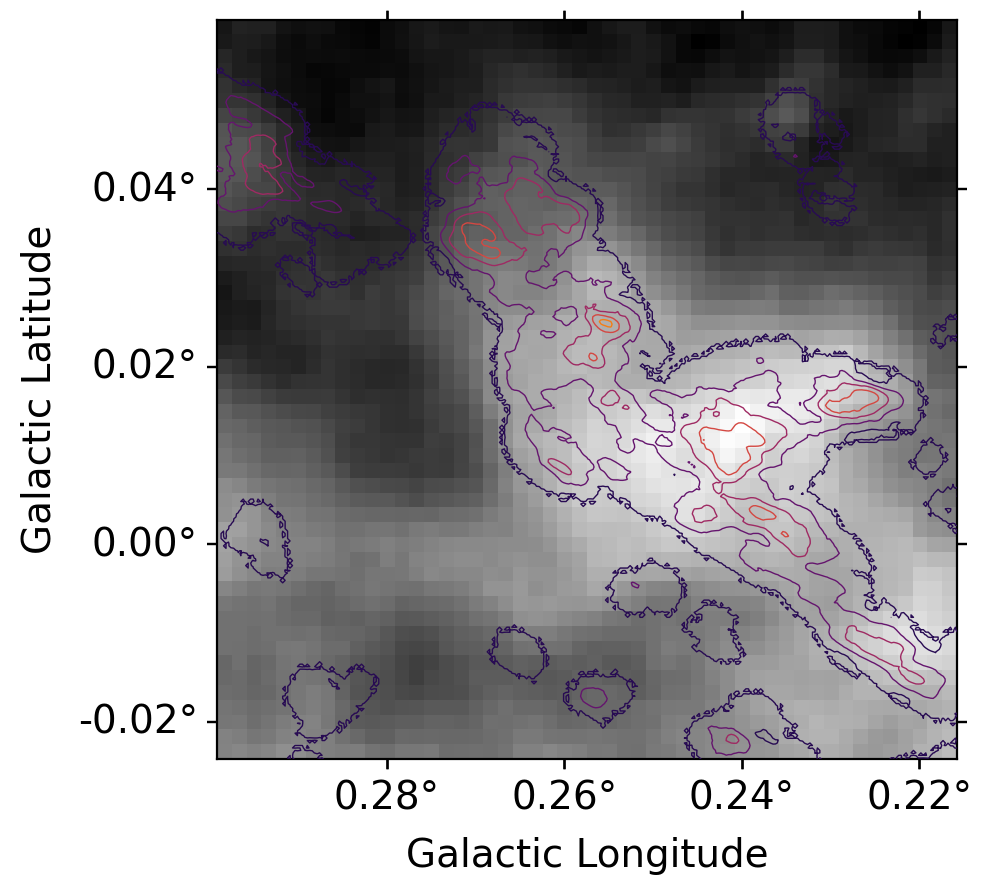

In [35]:
fig = pl.figure(dpi=200)
ax = fig.add_subplot(projection=co_image_cutout_brick.wcs)
pl.imshow(co_image_cutout_brick.data, norm=simple_norm(co_image_cutout_brick.data, stretch='linear', ),
          cmap='gray')
ax.contour(n2hp[0].value, transform=ax.get_transform(n2hp.wcs.celestial),
           cmap='inferno', levels=6, linewidths=[0.5]*20)
ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Latitude')
ax.xaxis.set_units(u.deg)
ax.yaxis.set_units(u.deg)
lon = ax.coords['glon']
lat = ax.coords['glat']
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')

pl.savefig("CARMA_N2Hp_on_CO32.pdf", dpi=200, bbox_inches='tight')
pl.savefig("CARMA_N2Hp_on_CO32.png", dpi=200, bbox_inches='tight')
#brickreg[0].to_pixel(ax.wcs).plot(ax=ax);

In [39]:
n2hpcube = SpectralCube.read('/orange/adamginsburg/cmz/carma/combined_N2H+.fits')
brick_mom0_n2hp = n2hpcube.with_mask(n2hpcube > n2hpcube[:20,:,:].std()).spectral_slab(-10*u.km/u.s, 80*u.km/u.s).moment0(axis=0)
n2hp_image_cutout_brick = Cutout2D(brick_mom0_n2hp.value, brick_center, size=5*u.arcmin, wcs=brick_mom0_n2hp.wcs)

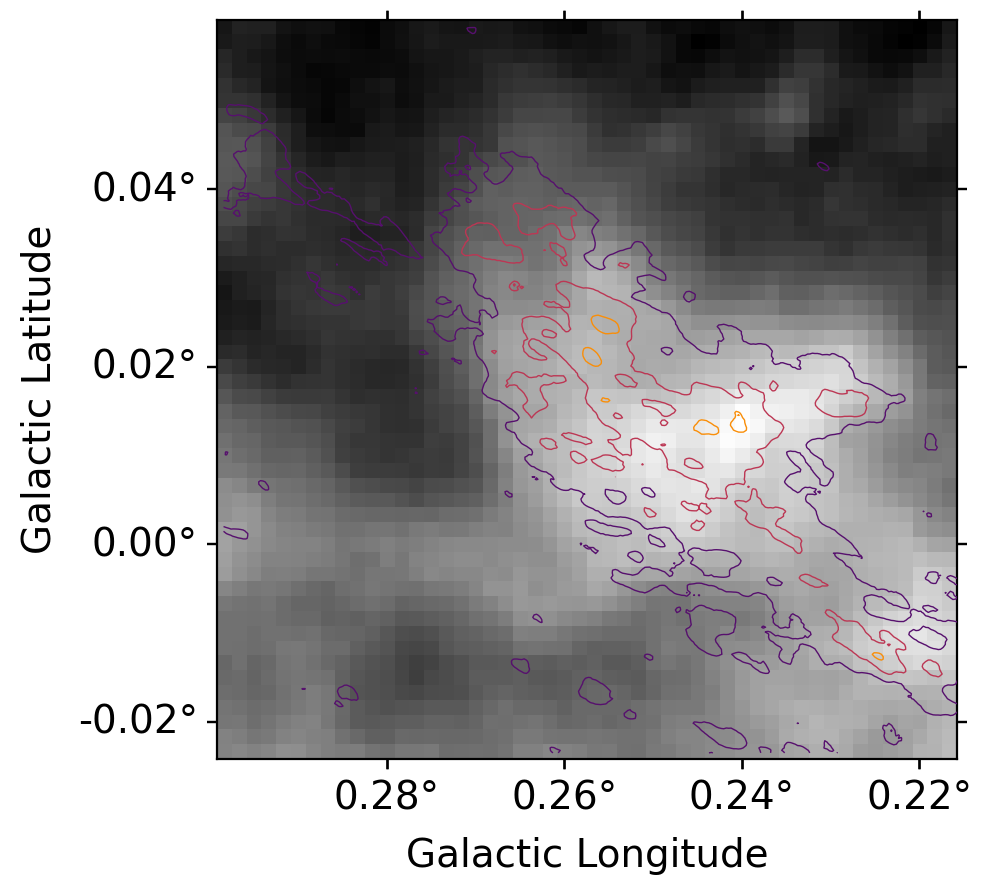

In [44]:
fig = pl.figure(dpi=200)
ax = fig.add_subplot(projection=co_image_cutout_brick.wcs)
pl.imshow(co_image_cutout_brick.data, norm=simple_norm(co_image_cutout_brick.data, stretch='linear', ),
          cmap='gray')
ax.contour(n2hp_image_cutout_brick.data, transform=ax.get_transform(n2hp_image_cutout_brick.wcs),
           cmap='inferno', levels=3, linewidths=[0.5]*20)
ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Latitude')
ax.xaxis.set_units(u.deg)
ax.yaxis.set_units(u.deg)
lon = ax.coords['glon']
lat = ax.coords['glat']
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')

pl.savefig("CARMAcomb_N2Hp_on_CO32.pdf", dpi=200, bbox_inches='tight')
pl.savefig("CARMAcomb_N2Hp_on_CO32.png", dpi=200, bbox_inches='tight')
#brickreg[0].to_pixel(ax.wcs).plot(ax=ax);

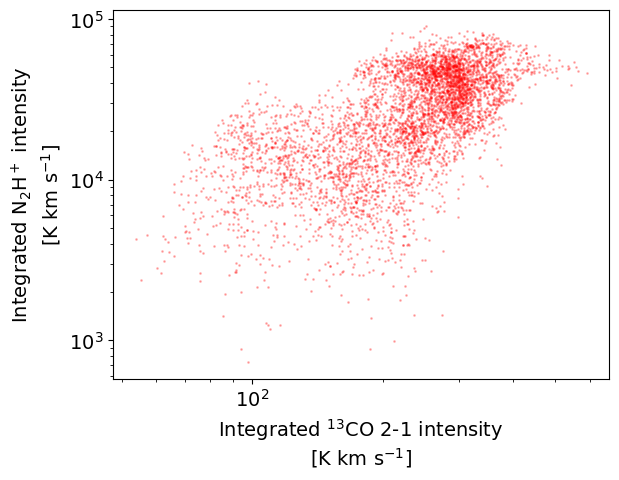

In [79]:
n2hp_to_johnston,_ = reproject.reproject_interp(brick_mom0_n2hp.hdu, mom0_Johnston.hdu.header)

#pl.scatter(dustridge_dust.data.ravel()*1e20, dustridge_13co.data.ravel(), s=1, c='k', alpha=0.1)

pl.scatter(mom0_Johnston.value[::5,::5].ravel(), n2hp_to_johnston[::5,::5].ravel(),  s=1, c='r', alpha=0.25)
co12to13 = 5
#pl.plot([1.2e22,0.95e23], [1e2/co12to13, 2e3/co12to13], linestyle='--', color='orange')
pl.loglog();
#pl.ylim(70/co12to13,2e3/co12to13)
pl.xlabel("Integrated $^{13}$CO 2-1 intensity\n[K km s$^{-1}$]");
pl.ylabel("Integrated N$_2$H$^+$ intensity\n[K km s$^{-1}$]");
pl.savefig("Brick_N2HpVsCO_integratedintensity.pdf", dpi=150, bbox_inches='tight')
pl.savefig("Brick_N2HpVsCO_integratedintensity.png", dpi=150, bbox_inches='tight')